In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Reshape
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#데이터 불러오기(경로)
train_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/test_x_df.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/capstone2021/sample_submission.csv')
train_x_df = train_x_df.astype('float')
train_y_df = train_y_df.astype('float')
test_x_df = test_x_df.astype('float')
sample_submission=sample_submission.astype('float')

In [3]:
# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 코인별 인덱스 뽑기
def coin_index_export(input_array, coin_num):

    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            #print(sample_id)
            index.append(sample_id)
    return index


# n분봉으로 나누는 함수
# idxsize= _array[0], time_size = _array[1], time_split = 몇분봉으로 나눌건지, arrayy = array명
def time_split(input_array, split_size = 6):

    # origin size define
    index_size = input_array.shape[0]
    origin_time_size = input_array.shape[1]
    variable_size = input_array.shape[2]

    # new array size define
    new_time_size = int(origin_time_size/split_size) # 1380 / 6
    new_array = np.zeros((index_size, new_time_size, variable_size))

    for idx in range(index_size):
        for time_idx in range(new_time_size):
            

            first_time_idx = time_idx * split_size
            last_time_idx = ((time_idx+1) * split_size) -1

            new_array[idx, time_idx, 0] = input_array[idx, first_time_idx, 0] #coin_num
            new_array[idx, time_idx, 1] = input_array[idx, first_time_idx, 1] #open
            
            new_array[idx, time_idx, 2] = np.max(input_array[idx, first_time_idx:last_time_idx, 2]) #high
            new_array[idx, time_idx, 3] = np.min(input_array[idx, first_time_idx:last_time_idx, 3]) #low

            new_array[idx, time_idx, 4] = input_array[idx, last_time_idx, 4] #close

            new_array[idx, time_idx, 5] = np.sum(input_array[idx, first_time_idx:last_time_idx, 5]) #etc
            new_array[idx, time_idx, 6] = np.sum(input_array[idx, first_time_idx:last_time_idx, 6]) #etc
            new_array[idx, time_idx, 7] = np.sum(input_array[idx, first_time_idx:last_time_idx, 7]) #etc
            new_array[idx, time_idx, 8] = np.sum(input_array[idx, first_time_idx:last_time_idx, 8]) #etc
            new_array[idx, time_idx, 9] = np.sum(input_array[idx, first_time_idx:last_time_idx, 9]) #etc

    return new_array
  
def create_datasettrain(signal_data, look_back):
  dataX, dataY = [], []
  for i in range(int(len(signal_data))):
    dataX.append(signal_data[i-look_back:i])
    dataY.append(signal_data[i])
  dataX = dataX[look_back:]
  dataY = dataY[look_back:]
  return np.array(dataX), np.array(dataY)

def create_datasettest(signal_data, look_back):
  dataX = []
  for i in range(int(len(signal_data))):
    dataX.append(signal_data[i-look_back:i])
  dataX = dataX[look_back:]
  return np.array(dataX)
def feature_normalization_by_last_idx(input_array):

    # origin size define
    index_size = input_array.shape[0]
    origin_time_size = input_array.shape[1]
    variable_size = input_array.shape[2]
    last_time_idx = origin_time_size - 1
    # new array size define
    new_array = np.zeros((index_size, origin_time_size, variable_size))

    for idx in range(index_size):
            

        new_array[idx, :, 0] = input_array[idx, :, 0] #coin_num
        new_array[idx, :, 1] = input_array[idx, :, 1] #open
            
        new_array[idx, :, 2] = input_array[idx, :, 2] #high
        new_array[idx, :, 3] = input_array[idx, :, 3] #low

        new_array[idx, :, 4] = input_array[idx, :, 4] #close

        new_array[idx, :, 5] = input_array[idx, :, 5]/input_array[idx, last_time_idx, 5]#etc
        new_array[idx, :, 6] = input_array[idx, :, 6]/input_array[idx, last_time_idx, 6] #etc
        new_array[idx, :, 7] = input_array[idx, :, 7]/input_array[idx, last_time_idx, 7] #etc
        new_array[idx, :, 8] = input_array[idx, :, 8]/input_array[idx, last_time_idx, 8] #etc
        new_array[idx, :, 9] = input_array[idx, :, 9]/input_array[idx, last_time_idx, 9] #etc

    return new_array

In [4]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [5]:
train_x_array = feature_normalization_by_last_idx(train_x_array)
train_y_array = feature_normalization_by_last_idx(train_y_array)
test_x_array = feature_normalization_by_last_idx(test_x_array)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/pyt

In [7]:
unique_coin_num = train_x_df.coin_index.nunique()

for coin_num in range(unique_coin_num):

    globals()['coin{}'.format(coin_num)] = coin_index_export(train_x_array, coin_num)

In [8]:
split_train_array = time_split(train_x_array, split_size=6)

In [9]:
timesize=6
#짜르고 해보자#
idx = coin9[-5]
signaldata=split_train_array[idx,:,:]
print(signaldata.shape[0])

signaldata = signaldata.reshape(int(len(train_x_array[1])/timesize),10)
print(signaldata.shape)
print(signaldata.shape[1])

230
(230, 10)
10


In [10]:
#look_back = y를 계산할때 몇개의 x sequence를 이용할건지#
look_back=6
train = signaldata[:int((1380/timesize)*0.8),:]  # 전체 sequence 중 test set 제외 80%를 train set로 이용
val = signaldata[int((1380/timesize)*0.8)-look_back:int((1380/timesize)),:] # train, test set 제외 val set로 이용
test = signaldata[int((1260/timesize))-look_back:int(1380/timesize),:] # test set에 이용될 sequence


In [11]:
x_train, y_train= create_datasettrain(train, look_back)
x_val, y_val= create_datasettrain(val, look_back)
x_test = create_datasettest(test, look_back)

#변수 및 타겟 선택#
variable = [1]
x_train = x_train[:,:,variable]
x_val = x_val[:,:,variable]
x_test = x_test[:,:,variable]

target = [1]
y_train = y_train[:,target]
y_val = y_val[:,target]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)


(178, 6, 1)
(46, 6, 1)
(20, 6, 1)
(178, 1)
(46, 1)


In [12]:
#모델학습
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))


def train(x_train, y_train, n_epoch, n_batch, x_val, y_val):

    #모델
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1],x_train.shape[2] )))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    # 모델 학습과정 설정하기
    model.compile(loss='mean_squared_error', optimizer='adam')

    # 모델 학습시키기
    custom_hist = CustomHistory()
    custom_hist.init()

    #모델 돌려보기
    model.fit(x_train, y_train, epochs=n_epoch, batch_size=n_batch, shuffle=True, callbacks=[custom_hist], validation_data=(x_val, y_val), verbose=1)

    return model

In [13]:
print(x_train.shape)
print(y_train.shape)

(178, 6, 1)
(178, 1)


In [14]:
#Build the model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape= (x_train.shape[1],x_train.shape[2] )))
model.add(LSTM(50,return_sequences=False,activation = 'relu'))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_val,y_val),shuffle=False)

Epoch 1/100
6/6 [==============================] - 25s 199ms/step - loss: 0.8607 - val_loss: 0.5246
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4322 - val_loss: 0.1403
Epoch 3/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0819 - val_loss: 0.0330
Epoch 4/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0561 - val_loss: 0.0310
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0163 - val_loss: 0.0064
Epoch 6/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0108 - val_loss: 0.0162
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0127 - val_loss: 0.0012
Epoch 8/100
6/6 [==============================] - 0s 18ms/step - loss: 7.7039e-04 - val_loss: 0.0033
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 10/100
6/6 [==============================] - 0s 16ms/step - loss: 5.8994e-04 - val_loss: 5.3181e-04
Epoch

In [18]:
#autoregression trial
look_ahead = 20
yhat=[]
x = signaldata[-look_back:,variable]
x=x.reshape(1,look_back,1)
for i in range(look_ahead):
  fc = model.predict(x)
  yhat.append(fc)
  x=np.append(x,fc)
  x=np.delete(x,0)
  x=x.reshape(1,6,1)


In [19]:
yhat=np.array(yhat)
yhat=yhat.reshape(look_ahead,)

In [24]:
pracx = signaldata
x_prac, y_prac= create_datasettrain(pracx, look_back)
x_prac = x_prac[:,:,variable]
x_prac.shape

(224, 6, 1)

In [25]:
#테스트 셋 돌린 결과 수집
predictions = model.predict(x_prac)
predictions.shape


(224, 1)

In [26]:
#테스트 셋 평가 위한 y 추출
col =[]
for i in range(int(len(train_x_array[1])/timesize)):
  col.append(i*timesize)

y_test = train_x_array[idx,col,target]

30
Model : LSTM
input data : 6분봉의 t-20 ~ t-1 의 high, low
output data : t 시점의 open


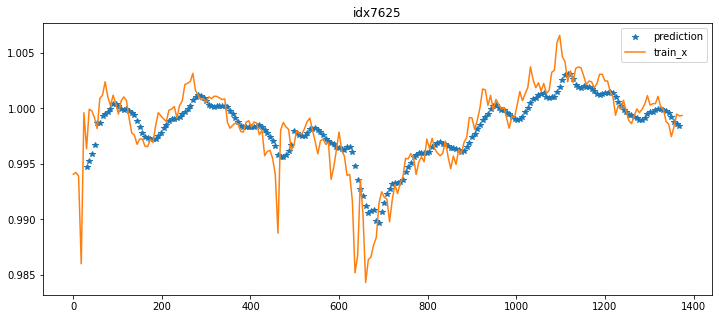

MSE


In [27]:
#train 결과만 시각화
x_values = []
for x in range(x_prac.shape[0]):
  x_values.append(look_back*(timesize) + timesize*(x-1))
#print(a)
y_values = []
for x in range(230):
  y_values.append(6*x)
print(x_values[0])

aa = predictions.tolist()
print("Model : LSTM")
print("input data : 6분봉의 t-20 ~ t-1 의 high, low")
print("output data : t 시점의 open")
plt.figure(figsize=(12,5))
plt.title('idx'+str(idx))
plt.plot(x_values,(aa),'*',label="prediction")
#plt.plot(train_x_array[idx,:,1],label="train_x")
plt.plot(y_values,signaldata[:,1],label="train_x")

#plt.plot(y_values,train_y_array[idx,:,1],label = "train_y")
plt.legend()
plt.show()
print("MSE")
#print(model.evaluate(x_test,y_test, batch_size=1))

In [28]:
#test array
split_test_array = time_split(train_y_array, split_size=6)
x_test=split_test_array[idx,:,variable]
x_test = x_test.reshape(20,)

In [29]:
x_test[0]

1.000080704689026

In [30]:
MSE = 0
for i in range(look_ahead):
  MSE += (x_test[i]-yhat[i])*(x_test[i]-yhat[i])
MSE = MSE*10E5/look_ahead
print(MSE)

6.490759391652962


Model : LSTM
input data : 6분봉의 t-6 ~ t-1 의 open
output data : t 시점의 open


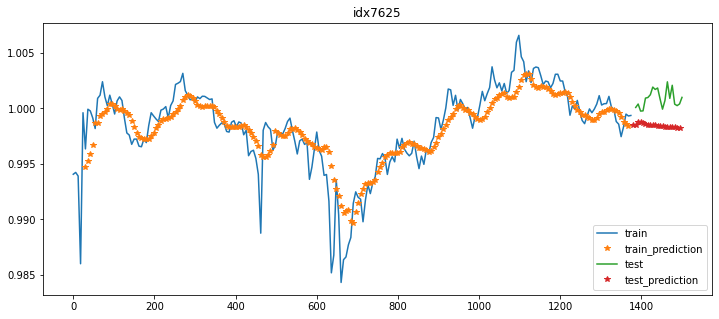

MSE * 10E5 =6.490759391652962


In [31]:
#test, train 결과 같이보기
x_values1 = []
for x in range(int(120/timesize)):
  x_values1.append(timesize*x+1380)
x_values = []
for x in range(x_prac.shape[0]):
  x_values.append(look_back*(timesize) + timesize*(x-1))
#print(a)
y_values = []
for x in range(230):
  y_values.append(6*x)

y_values1 = []
for x in range(int(120/timesize)):
  y_values1.append(timesize*(x+1)+1380)


print("Model : LSTM")
print("input data : 6분봉의 t-6 ~ t-1 의 open")
print("output data : t 시점의 open")

plt.figure(figsize=(12,5))
plt.title('idx'+str(idx))
plt.plot(y_values,signaldata[:,1],label="train")
plt.plot(x_values,aa,'*',label="train_prediction")
#plt.plot(train_x_array[idx,:,1],label="train_x")

plt.plot(y_values1,x_test, label="test")
plt.plot(x_values1,(yhat),'*',label="test_prediction")
#plt.plot(np.arange(1380,1500),train_y_array[idx,:,1],label="test function")
plt.legend()
plt.show()
print("MSE * 10E5 =" + str(MSE))
